In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import zipfile

ModuleNotFoundError: No module named 'LOFO'

In [3]:
zf = zipfile.ZipFile(r'C:\Users\nishantjairath\Downloads\train.csv.zip')

In [4]:
#reading zipped file contents
zf.namelist()

['train.csv']

In [5]:
df_train = pd.read_csv(zf.open('train.csv'))

In [6]:
df_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


#Feature Engineering

In [7]:
def engineer_features(df):
    df["u_in_sum"] = df.groupby("breath_id")["u_in"].transform("sum")
    df["u_in_cumsum"] = df.groupby("breath_id")["u_in"].cumsum()
    df["u_in_std"] = df.groupby("breath_id")["u_in"].transform("std")
    df["u_in_min"] = df.groupby("breath_id")["u_in"].transform("min")
    df["u_in_max"] = df.groupby("breath_id")["u_in"].transform("max")
    df["u_in_cumsum_reverse"] = df["u_in_sum"] - df["u_in_cumsum"]
    
    #lag lead features
    df["u_in_lag1"] = df.groupby("breath_id")["u_in"].shift(1)
    df["u_in_lead1"] = df.groupby("breath_id")["u_in"].shift(-1)
    df["u_in_lag1_diff"] = df["u_in"] - df["u_in_lag1"]
    df["u_in_lead1_diff"] = df["u_in"] - df["u_in_lead1"]
    
    #timepassed
    df["time_passed"] = df.groupby("breath_id")["time_step"].diff()
    
    return df

df_train = engineer_features(df_train)

In [8]:
df_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_sum,u_in_cumsum,u_in_std,u_in_min,u_in_max,u_in_cumsum_reverse,u_in_lag1,u_in_lead1,u_in_lag1_diff,u_in_lead1_diff,time_passed
0,1,1,20,50,0.000000,0.083334,0,5.837492,811.680524,0.083334,10.12367,0.0,28.313036,811.597190,NaN,18.383041,NaN,-18.299707,NaN
1,2,1,20,50,0.033652,18.383041,0,5.907794,811.680524,18.466375,10.12367,0.0,28.313036,793.214149,0.083334,22.509278,18.299707,-4.126236,0.033652
2,3,1,20,50,0.067514,22.509278,0,7.876254,811.680524,40.975653,10.12367,0.0,28.313036,770.704871,18.383041,22.808822,4.126236,-0.299544,0.033862
3,4,1,20,50,0.101542,22.808822,0,11.742872,811.680524,63.784476,10.12367,0.0,28.313036,747.896049,22.509278,25.355850,0.299544,-2.547028,0.034028
4,5,1,20,50,0.135756,25.355850,0,12.234987,811.680524,89.140326,10.12367,0.0,28.313036,722.540198,22.808822,27.259866,2.547028,-1.904016,0.034213


In [150]:
in_df = df_train[df_train["u_out"]== 0].reset_index(drop = True)
in_df.shape

(2290968, 19)

In [97]:
from lofo import Dataset, LOFOImportance, plot_importance
from sklearn.model_selection import GroupKFold

cv = list(GroupKFold(n_splits = 4).split(in_df, in_df["pressure"], groups = in_df["breath_id"]))

features = ["time_step", "u_in", "R", "C",
            "u_in_sum", "u_in_cumsum", "u_in_std", "u_in_min", "u_in_max", "u_in_cumsum_reverse",
            "u_in_lead1", "u_in_lag1", "u_in_lag1_diff", "u_in_lead1_diff", "time_passed"]


ds = Dataset(in_df, target="pressure", features=features, feature_groups=None, auto_group_threshold=0.9)

Automatically grouped features by correlation:
1 ['u_in_max', 'u_in_std', 'u_in_sum']


In [15]:
lofo_imp = LOFOImportance(ds, cv = cv, scoring = "neg_mean_absolute_error")

importance_df = lofo_imp.get_importance()
importance_df

  0%|          | 0/13 [00:00<?, ?it/s]

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
2,R,0.815442,0.011397,0.820640,0.808174,0.831268,0.801685
4,C,0.638743,0.005826,0.640228,0.630483,0.637527,0.646733
12,u_in_max & u_in_std & u_in_sum,0.123297,0.004305,0.127476,0.119338,0.118661,0.127713
11,u_in_cumsum,0.117904,0.001784,0.117497,0.118740,0.120117,0.115264
5,time_passed,0.108657,0.005660,0.114237,0.099512,0.112314,0.108565
9,time_step,0.062675,0.004033,0.068723,0.063834,0.058308,0.059836
3,u_in_lead1_diff,0.022919,0.006031,0.030723,0.026541,0.015446,0.018967
0,u_in_lag1_diff,0.019886,0.005049,0.025909,0.012547,0.018202,0.022887
1,u_in_lead1,0.019657,0.004668,0.027357,0.018909,0.017438,0.014925
10,u_in_lag1,0.017177,0.004250,0.021256,0.018587,0.018824,0.010042


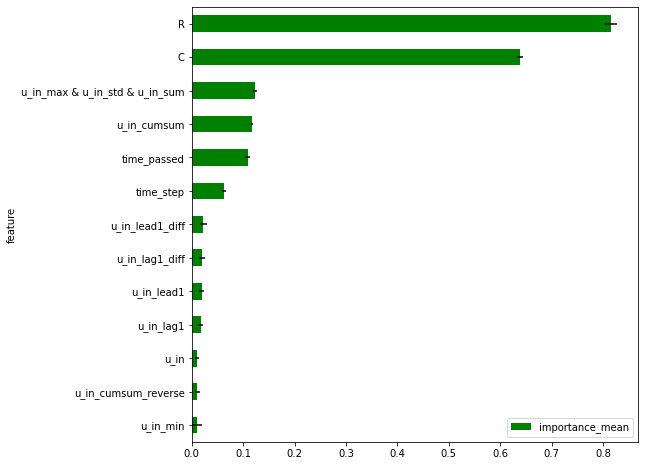

In [16]:
plot_importance(importance_df)

In [99]:
in_df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_sum,u_in_cumsum,u_in_std,u_in_min,u_in_max,u_in_cumsum_reverse,u_in_lag1,u_in_lead1,u_in_lag1_diff,u_in_lead1_diff,time_passed
1,2,1,20,50,0.033652,18.383041,0,5.907794,811.680524,18.466375,10.12367,0.0,28.313036,793.214149,0.083334,22.509278,18.299707,-4.126236,0.033652
2,3,1,20,50,0.067514,22.509278,0,7.876254,811.680524,40.975653,10.12367,0.0,28.313036,770.704871,18.383041,22.808822,4.126236,-0.299544,0.033862
3,4,1,20,50,0.101542,22.808822,0,11.742872,811.680524,63.784476,10.12367,0.0,28.313036,747.896049,22.509278,25.355850,0.299544,-2.547028,0.034028
4,5,1,20,50,0.135756,25.355850,0,12.234987,811.680524,89.140326,10.12367,0.0,28.313036,722.540198,22.808822,27.259866,2.547028,-1.904016,0.034213
5,6,1,20,50,0.169698,27.259866,0,12.867706,811.680524,116.400192,10.12367,0.0,28.313036,695.280332,25.355850,27.127486,1.904016,0.132380,0.033942


In [153]:
in_df.isnull().sum()

id                     0
breath_id              0
R                      0
C                      0
time_step              0
u_in                   0
u_out                  0
pressure               0
u_in_sum               0
u_in_cumsum            0
u_in_std               0
u_in_min               0
u_in_max               0
u_in_cumsum_reverse    0
u_in_lag1              0
u_in_lead1             0
u_in_lag1_diff         0
u_in_lead1_diff        0
time_passed            0
dtype: int64

In [152]:
in_df = in_df.fillna(method='backfill')

In [154]:
y = in_df["pressure"]
y.head()

0     5.837492
1     5.907794
2     7.876254
3    11.742872
4    12.234987
Name: pressure, dtype: float64

In [155]:
X = in_df
X.drop("pressure", axis = 1, inplace = True)

In [156]:
#train test split on original dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 0) 

In [157]:
#Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=5, random_state=0)

In [158]:
y_pred = regressor.predict(X_test)
y_pred

array([26.21105346, 37.99369303, 17.18425798, ..., 13.75351328,
       22.38661674, 27.23746478])

In [159]:
#Evaluating model performance - R square

from sklearn.metrics import r2_score
r_square = r2_score(y_test, y_pred)
r_square

0.9880878891298543

In [160]:
#Evaluating model performance - Adj R square
adj_r2 = 1 - (((1 - r_square)*(len(y_test)-1))/(len(y_test)-19-1))
adj_r2

0.9880876068590344

In [ ]:
# Random Forest Regression with 2 predictors - R2 = 0.5385964906305962, Adj R2 = 0.5385615424382562
# Random Forest Regression with 4 predictors - R2 = 0.5410316652268536, Adj R2 = 0.5409621324715193

In [109]:
#XGBoost
from xgboost import XGBRegressor
regressor_xgb = XGBRegressor()
regressor_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [110]:
y_pred_xgb = regressor_xgb.predict(X_test)

In [111]:
r_square_xgb = r2_score(y_test, y_pred_xgb)
r_square_xgb

0.9669342095857084

#Using Catboost model

In [112]:
from catboost import CatBoostRegressor
regressor_cat = CatBoostRegressor()
regressor_cat.fit(X_train, y_train)

Learning rate set to 0.129183
0:	learn: 8.3414986	total: 205ms	remaining: 3m 25s
1:	learn: 7.6562620	total: 358ms	remaining: 2m 58s
2:	learn: 7.0907506	total: 485ms	remaining: 2m 41s
3:	learn: 6.6060728	total: 613ms	remaining: 2m 32s
4:	learn: 6.1708438	total: 760ms	remaining: 2m 31s
5:	learn: 5.8098359	total: 889ms	remaining: 2m 27s
6:	learn: 5.4944535	total: 1.02s	remaining: 2m 24s
7:	learn: 5.2225637	total: 1.15s	remaining: 2m 22s
8:	learn: 4.9819565	total: 1.27s	remaining: 2m 19s
9:	learn: 4.7782270	total: 1.42s	remaining: 2m 20s
10:	learn: 4.6024913	total: 1.53s	remaining: 2m 17s
11:	learn: 4.4291097	total: 1.66s	remaining: 2m 16s
12:	learn: 4.2767049	total: 1.78s	remaining: 2m 14s
13:	learn: 4.1587768	total: 1.9s	remaining: 2m 13s
14:	learn: 4.0477468	total: 2.02s	remaining: 2m 12s
15:	learn: 3.9396349	total: 2.15s	remaining: 2m 12s
16:	learn: 3.8580871	total: 2.27s	remaining: 2m 11s
17:	learn: 3.7869668	total: 2.38s	remaining: 2m 10s
18:	learn: 3.6989844	total: 2.49s	remaining: 

158:	learn: 2.0738900	total: 18.3s	remaining: 1m 36s
159:	learn: 2.0708649	total: 18.4s	remaining: 1m 36s
160:	learn: 2.0665364	total: 18.5s	remaining: 1m 36s
161:	learn: 2.0623767	total: 18.6s	remaining: 1m 36s
162:	learn: 2.0608749	total: 18.7s	remaining: 1m 36s
163:	learn: 2.0578483	total: 18.8s	remaining: 1m 35s
164:	learn: 2.0556452	total: 18.9s	remaining: 1m 35s
165:	learn: 2.0532130	total: 19s	remaining: 1m 35s
166:	learn: 2.0511706	total: 19.1s	remaining: 1m 35s
167:	learn: 2.0501067	total: 19.2s	remaining: 1m 35s
168:	learn: 2.0478135	total: 19.3s	remaining: 1m 35s
169:	learn: 2.0447883	total: 19.5s	remaining: 1m 35s
170:	learn: 2.0417229	total: 19.6s	remaining: 1m 34s
171:	learn: 2.0403614	total: 19.7s	remaining: 1m 34s
172:	learn: 2.0379476	total: 19.8s	remaining: 1m 34s
173:	learn: 2.0354958	total: 19.9s	remaining: 1m 34s
174:	learn: 2.0340338	total: 20s	remaining: 1m 34s
175:	learn: 2.0303453	total: 20.1s	remaining: 1m 34s
176:	learn: 2.0288046	total: 20.2s	remaining: 1m 3

314:	learn: 1.8180303	total: 38.7s	remaining: 1m 24s
315:	learn: 1.8167070	total: 38.9s	remaining: 1m 24s
316:	learn: 1.8158290	total: 39s	remaining: 1m 24s
317:	learn: 1.8150308	total: 39.2s	remaining: 1m 23s
318:	learn: 1.8138532	total: 39.3s	remaining: 1m 23s
319:	learn: 1.8125313	total: 39.4s	remaining: 1m 23s
320:	learn: 1.8111997	total: 39.6s	remaining: 1m 23s
321:	learn: 1.8099817	total: 39.7s	remaining: 1m 23s
322:	learn: 1.8087170	total: 39.9s	remaining: 1m 23s
323:	learn: 1.8079332	total: 40s	remaining: 1m 23s
324:	learn: 1.8062717	total: 40.1s	remaining: 1m 23s
325:	learn: 1.8055419	total: 40.2s	remaining: 1m 23s
326:	learn: 1.8046883	total: 40.4s	remaining: 1m 23s
327:	learn: 1.8032501	total: 40.5s	remaining: 1m 23s
328:	learn: 1.8027706	total: 40.7s	remaining: 1m 22s
329:	learn: 1.8007519	total: 40.8s	remaining: 1m 22s
330:	learn: 1.7996712	total: 40.9s	remaining: 1m 22s
331:	learn: 1.7989466	total: 41.1s	remaining: 1m 22s
332:	learn: 1.7977616	total: 41.2s	remaining: 1m 2

470:	learn: 1.6864048	total: 1m	remaining: 1m 7s
471:	learn: 1.6861083	total: 1m	remaining: 1m 7s
472:	learn: 1.6850237	total: 1m	remaining: 1m 7s
473:	learn: 1.6846128	total: 1m	remaining: 1m 7s
474:	learn: 1.6836359	total: 1m	remaining: 1m 7s
475:	learn: 1.6832099	total: 1m	remaining: 1m 6s
476:	learn: 1.6825128	total: 1m	remaining: 1m 6s
477:	learn: 1.6819371	total: 1m 1s	remaining: 1m 6s
478:	learn: 1.6814834	total: 1m 1s	remaining: 1m 6s
479:	learn: 1.6811998	total: 1m 1s	remaining: 1m 6s
480:	learn: 1.6808105	total: 1m 1s	remaining: 1m 6s
481:	learn: 1.6804645	total: 1m 1s	remaining: 1m 6s
482:	learn: 1.6802838	total: 1m 1s	remaining: 1m 6s
483:	learn: 1.6798798	total: 1m 1s	remaining: 1m 5s
484:	learn: 1.6794717	total: 1m 1s	remaining: 1m 5s
485:	learn: 1.6784661	total: 1m 2s	remaining: 1m 5s
486:	learn: 1.6778963	total: 1m 2s	remaining: 1m 5s
487:	learn: 1.6769291	total: 1m 2s	remaining: 1m 5s
488:	learn: 1.6763329	total: 1m 2s	remaining: 1m 5s
489:	learn: 1.6756879	total: 1m 2

628:	learn: 1.6076895	total: 1m 21s	remaining: 48.2s
629:	learn: 1.6071513	total: 1m 21s	remaining: 48s
630:	learn: 1.6068147	total: 1m 21s	remaining: 47.9s
631:	learn: 1.6064153	total: 1m 22s	remaining: 47.8s
632:	learn: 1.6059247	total: 1m 22s	remaining: 47.7s
633:	learn: 1.6055635	total: 1m 22s	remaining: 47.5s
634:	learn: 1.6053465	total: 1m 22s	remaining: 47.4s
635:	learn: 1.6049037	total: 1m 22s	remaining: 47.3s
636:	learn: 1.6044659	total: 1m 22s	remaining: 47.2s
637:	learn: 1.6039944	total: 1m 22s	remaining: 47s
638:	learn: 1.6035455	total: 1m 23s	remaining: 46.9s
639:	learn: 1.6031291	total: 1m 23s	remaining: 46.8s
640:	learn: 1.6027559	total: 1m 23s	remaining: 46.7s
641:	learn: 1.6025563	total: 1m 23s	remaining: 46.5s
642:	learn: 1.6016808	total: 1m 23s	remaining: 46.4s
643:	learn: 1.6012291	total: 1m 23s	remaining: 46.3s
644:	learn: 1.6007947	total: 1m 23s	remaining: 46.2s
645:	learn: 1.6005801	total: 1m 24s	remaining: 46s
646:	learn: 1.6001603	total: 1m 24s	remaining: 45.9s

784:	learn: 1.5452888	total: 1m 43s	remaining: 28.3s
785:	learn: 1.5449161	total: 1m 43s	remaining: 28.1s
786:	learn: 1.5445758	total: 1m 43s	remaining: 28s
787:	learn: 1.5443937	total: 1m 43s	remaining: 27.9s
788:	learn: 1.5439995	total: 1m 43s	remaining: 27.7s
789:	learn: 1.5433757	total: 1m 43s	remaining: 27.6s
790:	learn: 1.5429599	total: 1m 43s	remaining: 27.5s
791:	learn: 1.5425972	total: 1m 44s	remaining: 27.3s
792:	learn: 1.5421916	total: 1m 44s	remaining: 27.2s
793:	learn: 1.5417941	total: 1m 44s	remaining: 27.1s
794:	learn: 1.5415796	total: 1m 44s	remaining: 27s
795:	learn: 1.5409962	total: 1m 44s	remaining: 26.8s
796:	learn: 1.5407674	total: 1m 44s	remaining: 26.7s
797:	learn: 1.5404779	total: 1m 44s	remaining: 26.6s
798:	learn: 1.5396684	total: 1m 45s	remaining: 26.4s
799:	learn: 1.5392195	total: 1m 45s	remaining: 26.3s
800:	learn: 1.5390217	total: 1m 45s	remaining: 26.2s
801:	learn: 1.5386334	total: 1m 45s	remaining: 26s
802:	learn: 1.5384270	total: 1m 45s	remaining: 25.9s

942:	learn: 1.4980863	total: 2m 4s	remaining: 7.55s
943:	learn: 1.4978233	total: 2m 5s	remaining: 7.42s
944:	learn: 1.4976696	total: 2m 5s	remaining: 7.28s
945:	learn: 1.4974547	total: 2m 5s	remaining: 7.15s
946:	learn: 1.4972618	total: 2m 5s	remaining: 7.02s
947:	learn: 1.4968989	total: 2m 5s	remaining: 6.89s
948:	learn: 1.4966422	total: 2m 5s	remaining: 6.75s
949:	learn: 1.4963836	total: 2m 5s	remaining: 6.62s
950:	learn: 1.4962159	total: 2m 5s	remaining: 6.49s
951:	learn: 1.4959909	total: 2m 6s	remaining: 6.36s
952:	learn: 1.4957727	total: 2m 6s	remaining: 6.22s
953:	learn: 1.4955506	total: 2m 6s	remaining: 6.09s
954:	learn: 1.4952574	total: 2m 6s	remaining: 5.96s
955:	learn: 1.4951245	total: 2m 6s	remaining: 5.83s
956:	learn: 1.4948195	total: 2m 6s	remaining: 5.7s
957:	learn: 1.4946394	total: 2m 6s	remaining: 5.57s
958:	learn: 1.4943761	total: 2m 7s	remaining: 5.43s
959:	learn: 1.4942867	total: 2m 7s	remaining: 5.3s
960:	learn: 1.4941082	total: 2m 7s	remaining: 5.17s
961:	learn: 1.

In [113]:
y_pred_cat = regressor_cat.predict(X_test)

In [114]:
r_square_cat = r2_score(y_test, y_pred_cat)
r_square_cat

0.9732380517308189

# Test Data set

In [115]:
zf2 = zipfile.ZipFile(r'C:\Users\nishantjairath\Downloads\test.csv.zip')

In [162]:
df_test = pd.read_csv(zf2.open('test.csv'))

In [163]:
df_test = engineer_features(df_test)

In [136]:
df_test.shape

(4024000, 18)

In [170]:
df_test.isnull().sum()

id                     0
breath_id              0
R                      0
C                      0
time_step              0
u_in                   0
u_out                  0
u_in_sum               0
u_in_cumsum            0
u_in_std               0
u_in_min               0
u_in_max               0
u_in_cumsum_reverse    0
u_in_lag1              0
u_in_lead1             0
u_in_lag1_diff         0
u_in_lead1_diff        0
time_passed            0
dtype: int64

In [169]:
df_test = df_test.fillna(method="ffill")
df_test.shape

(4024000, 18)

In [171]:
y_pred_2 = regressor.predict(df_test)

In [140]:
y_pred_2

array([ 5.68282699,  6.03433771,  7.21541376, ..., 22.58346275,
       22.72406704, 22.52722104])

In [172]:
df_test["pressure"] = y_pred_2

In [173]:
submission = df_test[["id", "pressure"]]

In [144]:
submission.tail()

,id,pressure
4023995,4023996,22.963094
4023996,4023997,22.513161
4023997,4023998,22.583463
4023998,4023999,22.724067
4023999,4024000,22.527221


In [174]:
submission.to_csv(r'C:\Users\nishantjairath\Downloads\submission_others.csv', index = False)

#df = pd.DataFrame(X_test_2={"id": list_1, "pressure": list_2})
#df.to_csv(r"C:\Users\nishantjairath\Downloads\submission.csv", sep=',',index=False)

# Predicting output with Catboost

In [147]:
y_pred_3 = regressor_cat.predict(df_test)
df_test["pressure"] = y_pred_3

In [148]:
y_pred_3.shape

(4024000,)

In [149]:
submission = df_test[["id", "pressure"]]
submission.to_csv(r'C:\Users\nishantjairath\Downloads\submission_others_catboost.csv', index = False)